# Turtle Recall
A facial recognition model for turtles

https://zindi.africa/competitions/turtle-recall-conservation-challenge/data

# Imports

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from PIL import Image

In [5]:
print(f'TensorFlow version is {tf.__version__}')

TensorFlow version is 2.8.0


In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Dataset

First, we load the data. In addition to the turtles and images from the train.csv file, we also make use of extra_images.csv by concatenation with the train file. This yields substantially more (ca. 10.000) image files to later train the model on.

In [7]:
IMAGE_DIR = './data/images'

In [8]:
train = pd.read_csv("./data/train.csv")
extra_images = pd.read_csv("./data/extra_images.csv")

# Convert image_location strings to lowercase.
for row in [train]:
  row.image_location = row.image_location.apply(lambda x: x.lower())
  assert set(row.image_location.unique()) == set(['left', 'right', 'top'])

df = pd.concat(objs=[train, extra_images])

In [9]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}.')

The total number of turtles is 2265.
The mean number of training images per turtle is 5.65, and the median is 3.


As we can see, however, we don't get a lot of images per turtle on average. Actually, some 2000 turtles are represented with less than 10 images in the dataset, which leads to a huge imbalance. Hence, we decide not to make use of any turtle with less than `MIN_NR_IMGS`.

In [10]:
MIN_NR_IMGS = 10

im_per_turtle = images_per_turtle[images_per_turtle >= MIN_NR_IMGS].to_frame()
df = df[df.turtle_id.isin(im_per_turtle.index)].reset_index()

In [11]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles after removal is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is now '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}. \n'
      f'The smallest number of images per turtle is '
      f'{min(df.turtle_id.value_counts())}.')

The total number of turtles after removal is 253.
The mean number of training images per turtle is now 19.72, and the median is 14. 
The smallest number of images per turtle is 10.


In [12]:
print(df.shape)
df.head(3)

(4990, 4)


,index,image_id,image_location,turtle_id
0,0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,2,ID_RVATH2HZ,right,t_id_3b65X5Lw


We have now removed a significant portion of the data and are left with about 5000 images, which is still more than double the amount of the initial images in the `train.csv`. There is, however, still a huge imbalance in the dataset and the total number of files is quite small.

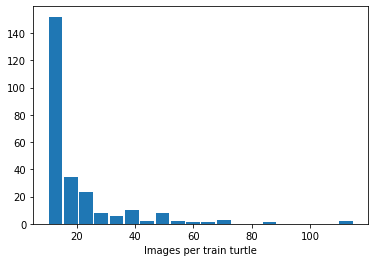

In [13]:
plt.hist(x=images_per_turtle, rwidth=0.9, bins=20)
plt.xlabel('Images per train turtle')
plt.show()

# Preprocessing

Create three mappings and get the paths to the training set image files.
1. `labels` : turtle ID --> unique integer labels
1. `label_lookup` : unique integer labels --> turtle ID
1. `image_to_turtle` :  image IDs to turtle IDs (training set only).

In [14]:
# required by current pipeline
turtle_ids = sorted(np.unique(df.turtle_id)) + ['new_turtle']

image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.split('.')[0] in df.image_id.values]
image_ids = [os.path.basename(f).split('.')[0] for f in image_files]

image_to_turtle = dict(zip(df.image_id, df.turtle_id))
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))

loaded_labels = [labels[image_to_turtle[id]] for id in image_ids]

In [15]:
# from tutorial.ipynb, but not currently used in pipeline
label_lookup = {v: k for k, v in labels.items()}
num_classes = len(labels)

image_turtle_ids = [image_to_turtle[id] for id in image_ids]

In [16]:
NUM_CLASSES = len(turtle_ids)
NUM_CLASSES

254

In [17]:
def crop_and_resize(pil_img, img_size=(224,224)):
  """Crop square from center of image and resize."""

  w, h = pil_img.size
  crop_size = min(w, h)
  crop = pil_img.crop(((w - crop_size) // 2, (h - crop_size) // 2,
                       (w + crop_size) // 2, (h + crop_size) // 2))
  
  return crop.resize(img_size)

tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]

100%|██████████| 4990/4990 [01:49<00:00, 45.48it/s]


(224, 224)
4990


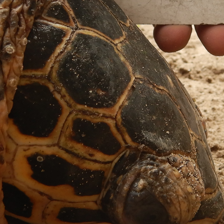

In [18]:
# inspect an image
print(loaded_images[0].size)
print(len(loaded_images))
loaded_images[0]

In [19]:
ims = tf.stack([tf.convert_to_tensor(np.asarray(im), dtype=tf.float32) for im in loaded_images])
labels = tf.stack(loaded_labels)

In [20]:
ds = tf.data.Dataset.from_tensor_slices((ims, labels))
ds.cardinality().numpy()

4990

In [21]:
ds = ds.map(lambda x,y: (x/255., tf.one_hot(y, NUM_CLASSES)))

### Data augmentation
https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/image_ops.ipynb#scrollTo=tbaIkUCS2eNv

In [22]:
from functions.image_augmentation import rotate_images, apply_mean_filter, apply_gaussian_filter, random_hsv, add_noise

In [23]:
#tf.keras.preprocessing.image.random_channel_shift
#tf.keras.preprocessing.image.random_brightness

We implemented a bunch of augmentation functions to deal with the small dataset. Below is an example of what an image with additive noise looks like.

2022-03-28 22:22:02.747488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


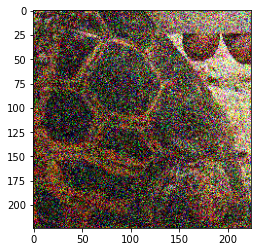

In [24]:
%matplotlib inline

example = ds.take(1).map(lambda x,y: (x + tf.random.normal(x.shape, mean=0.0, stddev=0.3, dtype=tf.float32), y))
example = example.map(lambda x,y: (tf.clip_by_value(x, 0.0, 1.0), y))

for elem in example.take(1):
    im, label = elem
plt.imshow(im)
plt.show()

In [25]:
ds_rotated = rotate_images(ds)
ds_gaussian = apply_gaussian_filter(ds)
ds_hsv = random_hsv(ds)
ds_noise = add_noise(ds, 0.2)

ds = ds.concatenate(ds_rotated).concatenate(ds_gaussian).concatenate(ds_hsv).concatenate(ds_noise)

print(f'Dataset contains {ds.cardinality().numpy()} images after data augmentation.')

Dataset contains 54890 images after data augmentation.


In [26]:
BATCH_SIZE = 128
TRAIN_SPLIT = np.round(ds.cardinality().numpy() * 0.8)
#VALID_SPLIT = 
TEST_SPLIT = np.round(ds.cardinality().numpy() * 0.2)

train = ds.take(TRAIN_SPLIT).shuffle(5000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = ds.skip(TEST_SPLIT).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

train = train.cache()
test = test.cache()

### Batches like done in tutorial.ipynb

In [ ]:
probability_per_label = {
    label: 1 / label_count / len(images_per_turtle)
    for label, label_count in images_per_turtle.items()
}

probabilities = [
    probability_per_label[image_turtle_id]
    for image_turtle_id in image_turtle_ids
]
assert np.isclose(1., np.sum(probabilities))


def get_batch(batch_size, rebalance=False):
  if rebalance:
    probs = probabilities
  else:
    probs = None
  batch_image_idxs = np.random.choice(
      len(image_files), size=batch_size, replace=False, p=probs)
  input_images = [loaded_images[idx] for idx in batch_image_idxs]
  image_labels = [labels[image_turtle_ids[idx]] for idx in batch_image_idxs]
  return (
      np.stack([np.asarray(im, dtype=np.float32) / 255. for im in input_images]), 
      np.stack(image_labels).astype(np.int32))

In [ ]:
batch_images, batch_labels = get_batch(batch_size=12)

_, axes = plt.subplots(nrows=2, ncols=6, figsize=(10, 4))
axes = axes.flatten()
for img, ax in zip(list(batch_images), axes):
  ax.imshow(img)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

print(batch_labels)

# Training

In [27]:
from functions.training_functions import training_loop
from models.alexNet import AlexNet

In [1]:
NR_EPOCHS = 2

alexnet = AlexNet()
adam = tf.keras.optimizers.Adam()
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

training_loop(train, test, alexnet, cce, adam, NR_EPOCHS)

NameError: name 'AlexNet' is not defined

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

resnet50 = ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224,224,3), 
    pooling='avg',)
resnet50.build(input_shape=(224,224,3))
#resnet50.summary()

In [ ]:
from models.customResNet50 import create_resnet50

In [ ]:
model = create_resnet50(NUM_CLASSES)
model.build(input_shape=(224,224,3))
model.summary()